# Categorização de Compras

# Importa Bibliotecas

In [1]:
from getpass import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from swat import *
import dlpy
from dlpy import *
from dlpy import Sequential
from dlpy.splitting import three_way_split
from dlpy.model import TextParms
from dlpy.blocks import Bidirectional
from dlpy.applications import TextClassification
from dlpy.metrics import accuracy_score, roc_auc_score, confusion_matrix
%matplotlib inline

# Connect to SAS Viya

In [2]:
sas = CAS('localhost', 5570, 'sasdemo', getpass('Please enter your passwod:'))

Please enter your passwod:········


# Load Action Sets

In [3]:
sas.loadactionset('fedSql')
sas.loadactionset('sampling')
print('Done!')

NOTE: Added action set 'fedSql'.
NOTE: Added action set 'sampling'.
Done!


# Load Data

In [4]:
des = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/ComprasDescID.csv',
                   sep=',',
                   quotechar='"',
                   casout=CASTable(name='des', replace=True))
print(des.columns)
print(des.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table DES in caslib CASUSER(sasdemo).
NOTE: The table DES has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['ID', 'DESCRI', 'NCM'], dtype='object')
(163933, 3)


In [5]:
des.head()

,ID,DESCRI,NCM
0,80230.0,OB-055 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,96032100.0
1,80231.0,OB-056 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,96032100.0
2,80232.0,OB-057 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,96032100.0
3,80233.0,OB-058 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,96032100.0
4,80234.0,OB-059 ESCOVA DENTAL ADT OBA OBA CX C/60 DZ,96032100.0


In [6]:
cat = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/ComprasCat2.csv',
                   sep=',',
                   quotechar='"',
                   casout=CASTable(name='cat', replace=True))
print(cat.columns)
print(cat.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table CAT in caslib CASUSER(sasdemo).
NOTE: The table CAT has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['ncm', 'cat'], dtype='object')
(6, 2)


In [7]:
cat.head()

,ncm,cat
0,33.0,ÓLEOS
1,34.0,SABÕES
2,96.0,OBRAS DIVERSAS
3,48.0,PAPÉIS
4,39.0,PLÁSTICOS


# Prepare Data

In [8]:
sas.fedsql.execdirect(
    '''
    create table data {options replace=True} as select
        a.ID as ID,
        a.DESCRI as DES,
        nvl(b.CAT,'OUTROS') as CAT
    from des as a
    left join cat as b
    on floor(a.NCM/1e6) = b.NCM
    '''
)
data = sas.CASTable('data')
print(data.columns)
print(data.shape)

NOTE: Table DATA was created in caslib CASUSER(sasdemo) with 163933 rows returned.
Index(['ID', 'DES', 'CAT'], dtype='object')
(163933, 3)


In [9]:
data.head()

,ID,DES,CAT
0,112999.0,TONAL C.KAMURA COL INT ROYAL 100 GR,ÓLEOS
1,113000.0,TONAL C.KAMURA COL INT TABACO 100 GR,ÓLEOS
2,113001.0,TONAL C.KAMURA HID FASH COB BLUE 100 GR,ÓLEOS
3,113002.0,TONAL C.KAMURA HID FASH INT VIOLET 100 G,ÓLEOS
4,113003.0,TONAL C.KAMURA HID FASH STAR PINK 100 GR,ÓLEOS


In [10]:
sas.fedsql.execdirect(
    '''
    select cat, sum(1) as cnt from data group by cat order by cnt desc
    '''
)

,CAT,CNT
0,ÓLEOS,131954
1,SABÕES,11886
2,OBRAS DIVERSAS,9464
3,OUTROS,2971
4,PAPÉIS,2958
5,PLÁSTICOS,2505
6,FERRAMENTAS,2195


# Stratified Sampling

In [11]:
data.groupby('cat') \
    .stratified(output={'casOut':{'name':'data', 'replace':True}, 'copyVars':'ALL'},
                samppct=80,
                samppct2=10,
                partind=True)

NOTE: Using SEED=1153730373 for sampling.


[outputSize]

 {'outputNObs': 163933.0, 'outputNVars': 4}

[STRAFreq]

 Frequencies
 
    ByGrpID             CAT    NObs  NSamp1  NSamp2
 0        0     FERRAMENTAS    2195    1756     220
 1        1  OBRAS DIVERSAS    9464    7572     946
 2        2           ÓLEOS  131954  105564   13195
 3        3          OUTROS    2971    2377     297
 4        4          PAPÉIS    2958    2366     296
 5        5       PLÁSTICOS    2505    2004     251
 6        6          SABÕES   11886    9508    1189

[OutputCasTables]

              casLib  Name Label    Rows  Columns  \
 0  CASUSER(sasdemo)  data        163933        4   
 
                                       casTable  
 0  CASTable('data', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.758s, user: 0.103s, sys: 0.225s, mem: 39.6mb

# Load Embeddings

Repositório de Word Embeddings do NILC (Núcleo Interinstitucional de Linguística Computacional)
- http://nilc.icmc.usp.br/embeddings

In [12]:
emb = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/glove_s50.txt',
                   sep=' ',
                   header=None,
                   skiprows=1,
                   casout=CASTable(name='emb', replace=True))
print(emb.columns)
print(emb.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table EMB in caslib CASUSER(sasdemo).
NOTE: The table EMB has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50'],
      dtype='object')
(929605, 51)


In [13]:
emb.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,cornissf,0.040483,0.096739,0.193614,0.244474,-0.045982,-0.120370,0.012879,0.170099,0.045384,...,-0.126742,0.040073,-0.071991,0.014067,-0.067611,-0.088228,0.061834,-0.066051,-0.013095,-0.075599
1,cornival,0.211197,0.269718,-0.021207,0.323456,0.103037,0.139978,-0.191722,-0.043407,0.002064,...,-0.232194,0.050281,0.099737,-0.020718,-0.130699,0.007039,-0.004389,0.003376,-0.064934,0.172048
2,cornouailles,0.160908,0.000095,-0.100483,0.302546,0.020267,0.035883,-0.220523,0.102298,0.269900,...,-0.114022,0.066827,-0.094612,-0.138976,-0.243849,0.020922,-0.071883,-0.162193,0.117461,0.058345
3,cornuaille,0.095801,-0.014405,-0.092568,0.210799,-0.014356,0.045003,-0.007758,-0.009375,-0.131345,...,-0.221641,-0.022493,0.093060,0.027430,-0.185305,-0.098066,0.112661,-0.211121,0.032072,0.038502
4,cornualhas,0.208060,0.086571,-0.033197,0.422422,0.053222,-0.084991,-0.178095,0.019823,-0.075660,...,-0.224765,0.022283,-0.115845,0.071618,-0.138007,-0.162179,0.071863,-0.133690,-0.251576,0.241686


# Train Model

In [15]:
model = TextClassification(sas,
                           model_table='bdlstm001',
                           neurons=100,
                           n_blocks=1,
                           rnn_type='LSTM')

NOTE: Output layer added.
NOTE: Model compiled successfully.


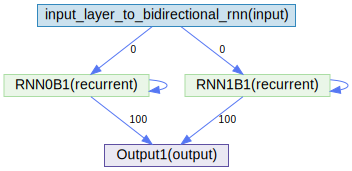

In [16]:
model.plot_network()

In [17]:
model.fit(data=data[data['_PartInd_']==0], 
          valid_table=data[data['_PartInd_']==1],
          inputs='des',
          texts='des',
          target='cat',
          nominals='cat',
          text_parms=TextParms(init_input_embeddings='emb', language='portuguese'),
          mini_batch_size=4, 
          max_epochs=100,
          lr=0.01,
          log_level=2)

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 122807.
NOTE:  The approximate memory cost is 19.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost      11.84 (s).
NOTE:  The total number of threads on each worker is 10.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 40.
NOTE:  Target variable: CAT
NOTE:  Number of levels for the target variable:      7
NOTE:  Levels for the target variable:
NOTE:  Level      0: FERRAMENTAS   
NOTE:  Level      1: OBRAS DIVERSAS
NOTE:  Level      2: ÓLEOS        
NOTE:  Level      3: OUTROS        
NOTE:  Level      4: PAPÉIS       
NOTE:  Level      5: PLÁSTICOS    
NOTE:  Level      6: SABÕES       
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation

NOTE:  82         0.01          0.1372    0.03898           0.3376          0.09171    16.02
NOTE:  83         0.01          0.1379    0.03807           0.2799          0.07001    15.75
NOTE:  84         0.01          0.1362    0.03819           0.2789          0.07284    16.80
NOTE:  85         0.01          0.1319    0.03636           0.2936           0.0763    15.25
NOTE:  86         0.01           0.132    0.03618           0.9526           0.2354    14.96
NOTE:  87         0.01          0.1533    0.04362           0.3363          0.09079    15.46
NOTE:  88         0.01          0.1316    0.03697           0.2707          0.06901    17.26
NOTE:  89         0.01          0.1282    0.03666           0.2716          0.06881    16.88
NOTE:  90         0.01          0.1265    0.03538           0.2696          0.06779    16.16
NOTE:  91         0.01          0.1218    0.03392           0.2777          0.07117    15.83
NOTE:  92         0.01          0.1214    0.03453           0.2757    

,Descr,Value
0,Model Name,bdlstm001
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,122000


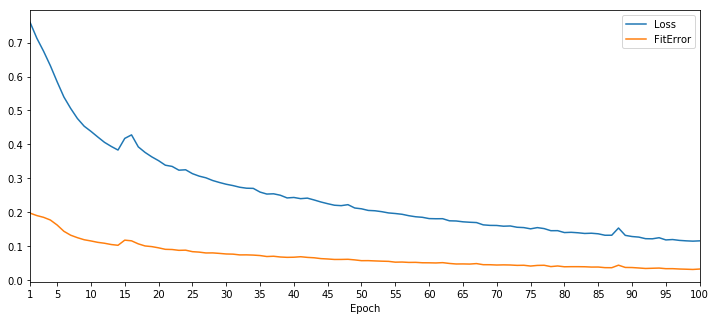

In [18]:
model.plot_training_history(tick_frequency=5)

In [27]:
res = \
model.predict(data[data['_PartInd_']==2],
              text_parms=TextParms(init_input_embeddings='emb', model_output_embeddings='bdsltm001'),
              use_best_weights=True,
              top_probs=2)
preds = res['OutputCasTables']['casTable'][0]
print(res['ScoreInfo'])

                               Descr         Value
0        Number of Observations Read         16394
1        Number of Observations Used         16394
2        Misclassification Error (%)      6.856167
3  Top 2 Misclassification Error (%)             0
4                         Loss Error      0.273818


In [28]:
cmx = preds.crosstab(row='CAT', col='_DL_PredName_')
print(cmx.Crosstab)

              CAT  Col1   Col2   Col3   Col4   Col5   Col6     Col7
0     FERRAMENTAS  79.0   54.0   12.0    0.0    4.0    2.0     69.0
1  OBRAS DIVERSAS   7.0  815.0    6.0    1.0    0.0    4.0    113.0
2          OUTROS   9.0   37.0  146.0    2.0   12.0   13.0     78.0
3          PAPÉIS   3.0   50.0    7.0  206.0    0.0    0.0     30.0
4       PLÁSTICOS   3.0   20.0    8.0    2.0  204.0    0.0     14.0
5          SABÕES   1.0   21.0    7.0    7.0    0.0  924.0    229.0
6           ÓLEOS  19.0  166.0   41.0    7.0    3.0   63.0  12896.0


# Train New Embeddings

In [17]:
sas.loadactionset('textMining')
sas.tmMine(docId="ID",
           documents="data", 
           entities="NONE",
           nounGroups=False,
           offset=dict(name='pos', replace=True),
           reduce=1,
           stemming=False,
           tagging=False,
           terms=dict(name='terms', replace=True),
           text="DES"
        )

NOTE: Added action set 'textMining'.


,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(sasdemo),pos,,944720,9,"CASTable('pos', caslib='CASUSER(sasdemo)')"
1,CASUSER(sasdemo),terms,,43507,11,"CASTable('terms', caslib='CASUSER(sasdemo)')"


In [18]:
sas.loadactionset('textUtil')
sas.tmCooccur(cooccurrence=dict(name='cooc', replace=True),
            maxDist=5,
            minCount=0,
            offset={"name":"pos"},
            ordered=False,
            terms={"name":"terms"},  
            useParentId=True
           )

NOTE: Added action set 'textUtil'.


[NObs]

 Input Data Statistics
 
                       Description      Value
 0   Number of sentences processed   170479.0
 1       Number of terms processed    43507.0
 2  Number of term pairs processed  2225208.0

[OutputCasTablesFull]

              casLib  Name Label     Rows  Columns  \
 0  CASUSER(sasdemo)  cooc        1070239        6   
 
                                       casTable  
 0  CASTable('cooc', caslib='CASUSER(sasdemo)')  

+ Elapsed: 9.15s, user: 11.6s, sys: 2.51s, mem: 346mb

In [19]:
sas.tmSvd(count="_association_",
        docId="_termid2_",
        maxK=50,
        parent={"name":"cooc"}, 
        termId="_termid1_",
        wordPro=dict(name='wordPro', replace=True)
       )

,casLib,Name,Label,Rows,Columns,casTable
0,CASUSER(sasdemo),wordPro,,43507,51,"CASTable('wordPro', caslib='CASUSER(sasdemo)')"


In [20]:
sas.execDirect(casout=dict(name='wordEmbedding', replace=True),
             query='select t._term_, d.* from wordPro d, terms t where d._termnum_=t._termnum_')

NOTE: Table wordEmbedding was created in caslib CASUSER(sasdemo) with 43507 rows returned.


+ Elapsed: 0.628s, user: 0.534s, sys: 0.185s, mem: 77.6mb

In [21]:
sas.datastep.runcode('data wordEmbedding(replace=yes); set wordEmbedding; drop _TermNum_; run;')

[InputCasTables]

              casLib           Name   Rows  Columns  \
 0  CASUSER(sasdemo)  wordEmbedding  43507       52   
 
                                             casTable  
 0  CASTable('wordEmbedding', caslib='CASUSER(sasd...  

[OutputCasTables]

              casLib           Name   Rows  Columns  Append  \
 0  CASUSER(sasdemo)  wordEmbedding  43507       51     NaN   
 
                                             casTable  
 0  CASTable('wordEmbedding', caslib='CASUSER(sasd...  

+ Elapsed: 0.367s, user: 0.229s, sys: 0.117s, mem: 17.5mb

In [22]:
sas.CASTable('wordEmbedding').head()

,_Term_,_Col1_,_Col2_,_Col3_,_Col4_,_Col5_,_Col6_,_Col7_,_Col8_,_Col9_,...,_Col41_,_Col42_,_Col43_,_Col44_,_Col45_,_Col46_,_Col47_,_Col48_,_Col49_,_Col50_
0,9/8,0.131105,0.078246,-0.057443,-0.049299,-0.167184,-0.243549,0.254193,-0.040849,0.022954,...,-0.002547,-0.005110,0.018175,0.050336,0.001179,0.028548,0.048767,-0.029766,-0.017263,-0.007741
1,deg,0.301528,0.116034,0.279764,0.074573,0.118770,0.001824,0.135237,0.148899,0.072082,...,-0.016056,-0.006238,0.002314,0.030748,0.097633,-0.071614,-0.155225,0.112017,-0.277561,0.045425
2,mid,0.532228,0.288100,0.361147,-0.155565,-0.160742,-0.114273,0.060152,0.055332,-0.163961,...,-0.030505,0.048542,0.025339,-0.200520,-0.006085,0.145398,0.090593,0.062127,0.034250,-0.084286
3,lomb,0.290682,-0.122125,0.066508,0.147065,-0.068237,-0.193151,-0.148151,0.215051,-0.300622,...,-0.058869,-0.108041,0.009724,0.038598,-0.171056,0.148729,-0.027748,-0.131580,0.010103,0.039204
4,ptes,0.343840,-0.046343,-0.148008,0.195799,-0.301495,0.261367,-0.088440,0.145143,0.144182,...,-0.235753,-0.049774,-0.035088,-0.022418,0.134345,-0.031693,0.039155,-0.006904,-0.003521,-0.081467


# Visualize the New Word Embeddings

In [ ]:
sas.loadactionset("tSne")
sas.tSne(output        = {"casOut":{"name":"tsne", "replace":True},
                          "copyVars":'_Term_'},
         inputs        = ['_Col%d_' % x for x in range(1,51)],
         nDimensions   = 2,
         perplexity    = 5,
         learningRate  = 100,
         maxIters      = 500,
         table         = 'wordEmbedding')

tsne_out=sas.CASTable('tsne')

In [ ]:
#plot

# Train New Model

In [43]:
model = TextClassification(sas,
                           model_table='bdlstm002',
                           neurons=100,
                           n_blocks=1,
                           rnn_type='LSTM')

NOTE: Output layer added.
NOTE: Model compiled successfully.


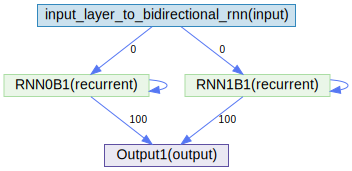

In [44]:
model.plot_network()

In [45]:
model.fit(data=data[data['_PartInd_']==0], 
          valid_table=data[data['_PartInd_']==1],
          inputs='des',
          texts='des',
          target='cat',
          nominals='cat',
          text_parms=TextParms(init_input_embeddings='wordEmbedding', language='portuguese'),
          mini_batch_size=4, 
          max_epochs=100,
          lr=0.01,
          log_level=2)

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 122807.
NOTE:  The approximate memory cost is 19.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       9.84 (s).
NOTE:  The total number of threads on each worker is 10.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 40.
NOTE:  Target variable: CAT
NOTE:  Number of levels for the target variable:      7
NOTE:  Levels for the target variable:
NOTE:  Level      0: FERRAMENTAS   
NOTE:  Level      1: OBRAS DIVERSAS
NOTE:  Level      2: ÓLEOS        
NOTE:  Level      3: OUTROS        
NOTE:  Level      4: PAPÉIS       
NOTE:  Level      5: PLÁSTICOS    
NOTE:  Level      6: SABÕES       
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation

NOTE:  79         0.01            0.14    0.04417           0.1802          0.05305    14.24
NOTE:  80         0.01          0.1404    0.04319            0.191          0.05627    14.15
NOTE:  81         0.01          0.1397    0.04301           0.1859          0.05424    14.27
NOTE:  82         0.01          0.1374    0.04203           0.1767          0.05251    14.10
NOTE:  83         0.01          0.1377    0.04215           0.1934          0.05632    14.15
NOTE:  84         0.01          0.1376    0.04246           0.1813          0.05378    14.06
NOTE:  85         0.01          0.1362    0.04118           0.1832          0.05386    14.13
NOTE:  86         0.01          0.1381    0.04215           0.1809          0.05382    14.83
NOTE:  87         0.01          0.1343    0.04081           0.1791          0.05225    14.55
NOTE:  88         0.01          0.1362    0.04179           0.1838          0.05425    14.24
NOTE:  89         0.01          0.1339    0.04106           0.1841    

,Descr,Value
0,Model Name,bdlstm002
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,122000


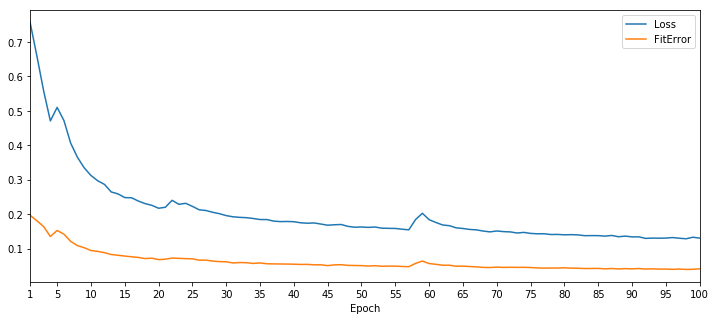

In [46]:
model.plot_training_history(tick_frequency=5)

In [47]:
res = \
model.predict(data[data['_PartInd_']==2],
              text_parms=TextParms(init_input_embeddings='wordEmbedding', model_output_embeddings='bdsltm002'),
              use_best_weights=True,
              top_probs=2)
preds = res['OutputCasTables']['casTable'][0]
print(res['ScoreInfo'])

                               Descr         Value
0        Number of Observations Read         16394
1        Number of Observations Used         16394
2        Misclassification Error (%)      4.885934
3  Top 2 Misclassification Error (%)             0
4                         Loss Error      0.167887


In [68]:
t = preds.tableinfo()['TableInfo']['Name'][0]
tmp = sas.CASTable('filtered')
for cat in ['FERRAMENTAS','OBRAS DIVERSAS','OUTROS','PAPÉIS','PLÁSTICOS','SABÕES','ÓLEOS']:
    sas.fedsql.execdirect('create table filtered {options replace=True} as select * from '+t+' where cat = \''+cat+'\'')
    acc = accuracy_score(tmp['CAT'], tmp['_DL_PredName_'], id_vars='ID')
    print('%s: %.4f' % (cat, acc))

NOTE: Table FILTERED was created in caslib CASUSER(sasdemo) with 220 rows returned.
FERRAMENTAS: 0.5955
NOTE: Table FILTERED was created in caslib CASUSER(sasdemo) with 946 rows returned.
OBRAS DIVERSAS: 0.9059
NOTE: Table FILTERED was created in caslib CASUSER(sasdemo) with 297 rows returned.
OUTROS: 0.5724
NOTE: Table FILTERED was created in caslib CASUSER(sasdemo) with 296 rows returned.
PAPÉIS: 0.8885
NOTE: Table FILTERED was created in caslib CASUSER(sasdemo) with 251 rows returned.
PLÁSTICOS: 0.8884
NOTE: Table FILTERED was created in caslib CASUSER(sasdemo) with 1189 rows returned.
SABÕES: 0.7990
NOTE: Table FILTERED was created in caslib CASUSER(sasdemo) with 13195 rows returned.
ÓLEOS: 0.9817


In [48]:
cmx = preds.crosstab(row='CAT', col='_DL_PredName_')
print(cmx.Crosstab)

              CAT   Col1   Col2   Col3   Col4   Col5   Col6     Col7
0     FERRAMENTAS  160.0   36.0    0.0    0.0    1.0    0.0     23.0
1  OBRAS DIVERSAS    6.0  876.0    2.0    1.0    0.0    0.0     61.0
2          OUTROS    6.0   40.0  165.0    3.0   13.0    4.0     66.0
3          PAPÉIS    0.0    8.0    3.0  264.0    0.0    7.0     14.0
4       PLÁSTICOS    3.0   11.0   12.0    0.0  220.0    0.0      5.0
5          SABÕES    1.0    7.0    6.0   10.0    0.0  953.0    212.0
6           ÓLEOS   16.0  124.0   24.0    3.0    0.0   73.0  12955.0


# Save Models

In [49]:
model.save_to_table('/home/sasdemo/demos/nlpCompras/models/bdlstm002')

NOTE: Model table saved successfully.


# Save Predictions

In [53]:
sas.addcaslib(name='compras',
              path='/home/sasdemo/demos/nlpCompras/data',
              datasource='path',
              session=False)

NOTE: 'compras' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'compras'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,compras,PATH,,/home/sasdemo/demos/nlpCompras/data/,,0.0,0.0,1.0,0.0,0.0,0.0


In [54]:
preds.save(caslib='compras', name='ComprasScored')
# preds.to_csv('/home/sasdemo/demos/nlpCompras/data/ComprasScored.csv')

NOTE: Cloud Analytic Services saved the file ComprasScored.sashdat in caslib compras.


[caslib]

 'compras'

[name]

 'ComprasScored.sashdat'

+ Elapsed: 0.0243s, user: 0.002s, sys: 0.016s, mem: 16.4mb

# Terminate Session

In [55]:
sas.terminate()

In [12]:
model = TextClassification(sas,
                           model_table='bdlstm002',
                           neurons=100,
                           n_blocks=1,
                           rnn_type='LSTM')

NOTE: Output layer added.
NOTE: Model compiled successfully.


In [13]:
model.load('/home/sasdemo/demos/nlpCompras/models/bdlstm002/bdlstm002.sashdat')

NOTE: bdlstm002_weights.sashdat is used as model weigths.
NOTE: Model weights attached successfully!
NOTE: bdlstm002_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!
